# ML Lab 3:

# Implementing Convolutional Neural Networks in PyTorch

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets

PyTorch is a library for Python programs that makes easier the creation of deep learning projects. PyTorch focuses on flexibility. It also allows to express deep learning models in idiomatic Python.
A deep learning model is a complex function mapping inputs to outputs. To make it easier to express such a function, PyTorch provides as a core data structure, the <code>Tensor</code>.
A tensor is a data structure to hold numbers, vectors, matrices or (multidimensional) arrays in general (a generalization of a matrix to more than 2 dimensions).


Installation
For installation information, please look at the Get Started guide on the PyTorch website (https://pytorch.org/get-started/locally).

## Recognizing handwritten numbers with PyTorch

### Data loading and preparation

The `torchvision.datasets` module contains data sets objects for many vision data in the real world.

We begin by downloading the MNIST dataset, which contains 70,000 examples of handwritten numbers 0-9 as 28x28 pixel images. We will use the `MNIST` class from the torchvision module for this purpose.


In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

target_directory = "mnist"

# Load MNIST from file
DATA_DIR = "."
download_dataset = True

mnist_real_train = datasets.MNIST(DATA_DIR, train=True, download=download_dataset)
mnist_test = datasets.MNIST(DATA_DIR, train=False, download=download_dataset)

We have loaded two datasets, let's examine their length

In [4]:
len(mnist_real_train), len(mnist_test)

(60000, 10000)

A single mnist_train element consists of a pair: an image and its label

In [5]:
mnist_real_train[0][0]


In [6]:
mnist_real_train[0][1]

5

Let's check the image size

In [7]:
mnist_real_train[0][0].size

(28, 28)

Unfortunately, the images loaded this way are - well, images, not arrays of numbers.
Since data is not always presented in the final processed form necessary to train machine learning algorithms, PyTorch offers `transforms` to do some data manipulation and make them suitable for training.

We'll load the images again, but this time turning them immediately into two-dimensional tensors (objects of the `torch.Tensor` class).

In [8]:
import torchvision.transforms as transforms

def flatten(inp):
    return inp.reshape(-1)

transform = transforms.Compose([transforms.ToTensor()])

mnist_real_train = datasets.MNIST(DATA_DIR, train=True, download=download_dataset, transform=transform)
mnist_test = datasets.MNIST(DATA_DIR, train=False, download=download_dataset, transform=transform)

Let's examine the type and size of the tensor representing the first object in the learning set

In [9]:
type(mnist_real_train[0][0]), mnist_real_train[0][0].shape

(torch.Tensor, torch.Size([1, 28, 28]))

We will divide the learning set into two parts: an actual learning set of size $80\%\cdot 60000=48000$ and a validation set of size $20\%\cdot 60000=12000$

In [10]:
mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))
len(mnist_train), len(mnist_validation)

(48000, 12000)

## Building a neural network

### Convolutional neural network

A **convolutional neural network (CNN)** contains spatially local connections at least in the early layers, and has patterns of weights replicated in the units in each layer.  
The motivation is that an image cannot be regarded of as a simple vector of input pixels because adjacency of pixels is really important. Furthermore, for a megapixel RGB image and fully connected layers there will be vast parameter space.  

A pattern of weights that is replicated across multiple local regions is called **kernel**. The process of applying the kernel to the pixels of the image is called **convolution**.

### Convolutional layer

The *convolutional layer* moves the *kernel* over the image (in general: over the matrix) place by place, computes the result and stores it in the output matrix. In the following figure, we are dealing with an image of $7\times 5$ pixels (the light gray area at the bottom of the figure) over which the kernel is moved $3\times 3$ pixels. The image is *padded* with zeros, shown in dark gray. What is this padding for? Without it, the output matrix would be smaller than the input image. The red pixels in the output matrix are calculated as follows: each pixel of the input image is multiplied by its corresponding value in the filter, and the 9 values so obtained are added together. The same filter is then used to compute the next pixel - marked in blue - based on the input pixels marked with a blue dashed line. Filter are weights of the Convolutional  Neural Network, that is, it is subject to learning.

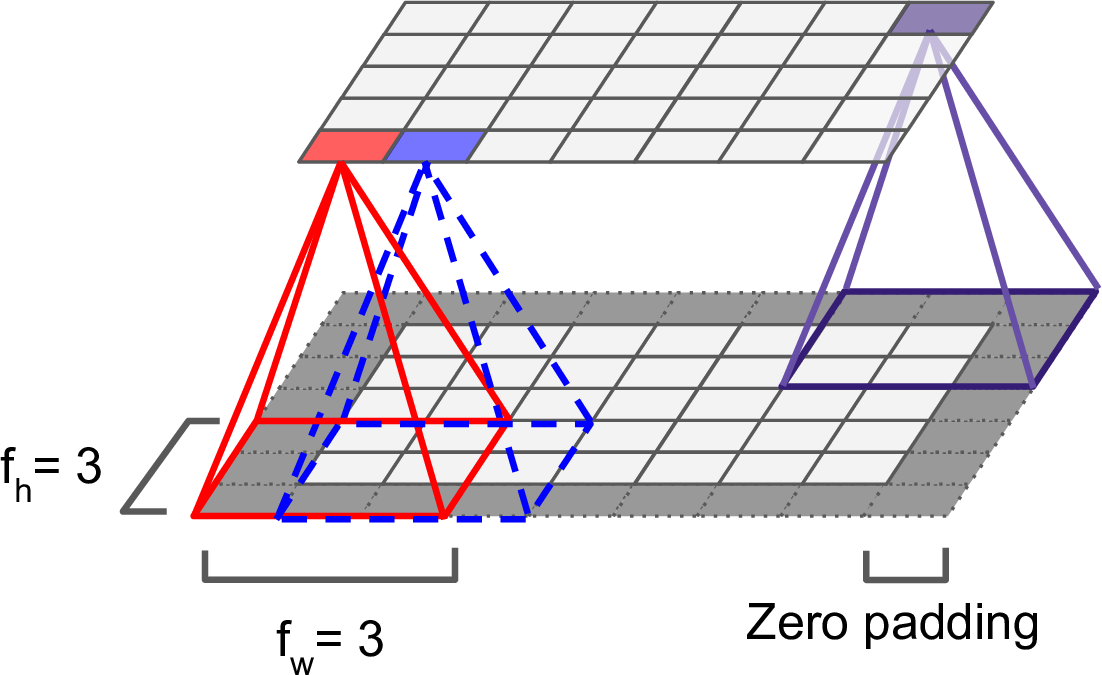


Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

The kernel does not have to move 1 pixel each time, it can have a larger step (*stride*), as in the following figure.

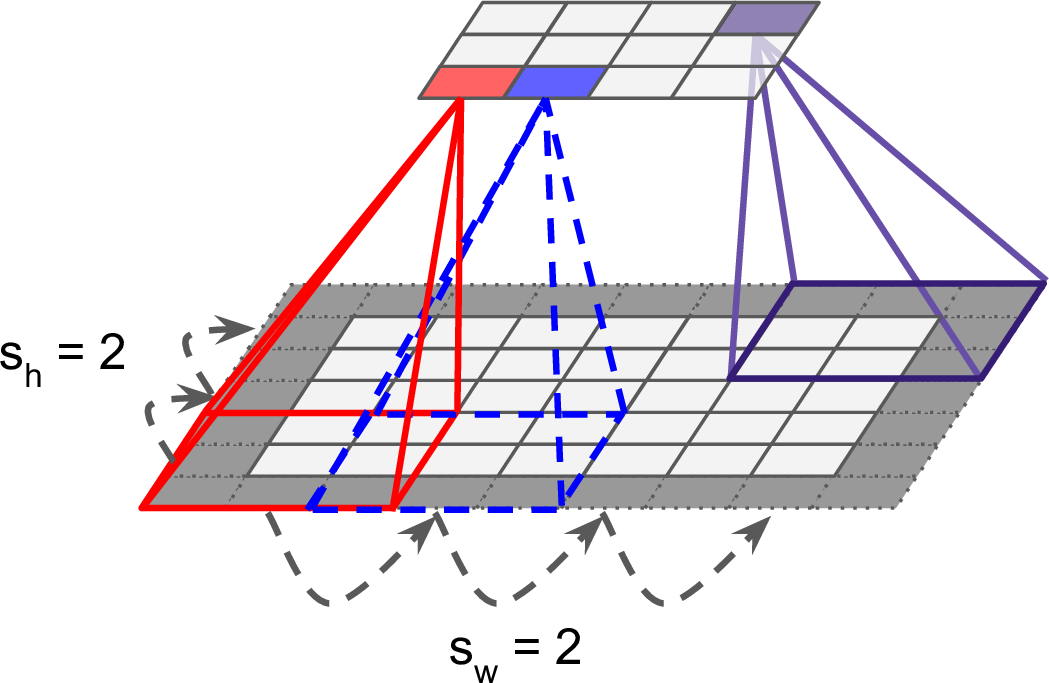
Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

More formally, we write the convolution operation using the symbol \*, for example: **z** = **x** \* **k**. Then for each output position *i*, we take a dot product between the kernel **k**  and **x** centered on *xi* with width *l*.

This process is shown in the following figure as an example of a one-dimensional convolution operation with a kernel [+1,-1,+1] that detects darker point in the 1D image and with a kernel of size *l* = 3 and a stride *s* = 2.

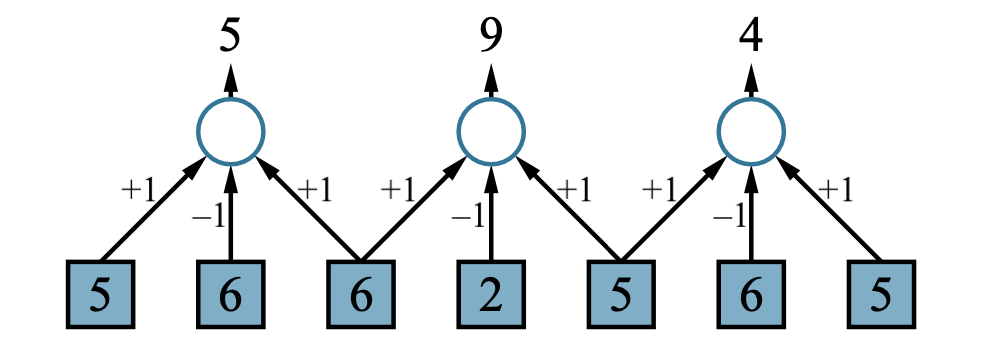

Figure from: 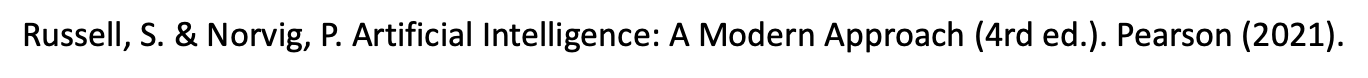

But, but... after all, pictures can be colored! In fact, we can see a single image as several monochromatic images. Then, instead of moving a flat filter over a single image, we move a cube whose two dimensions (responsible for the height and width) can be modified, while its depth is fixed - it depends on the number of layers in the image. In the figure below, we start with a normal RGB image, which is then converted into a tensor. Such a tensor is often called **feature map**, since it shows how each feature extracted by a kernel appears accross the entire image. We have multiple maps - each having its own single filter (cube) - thus creating a new "image" denoted *Convolutional layer 1*, on which... we repeat the operation! Using the new set of filters we create *Convolutional layer 2*.


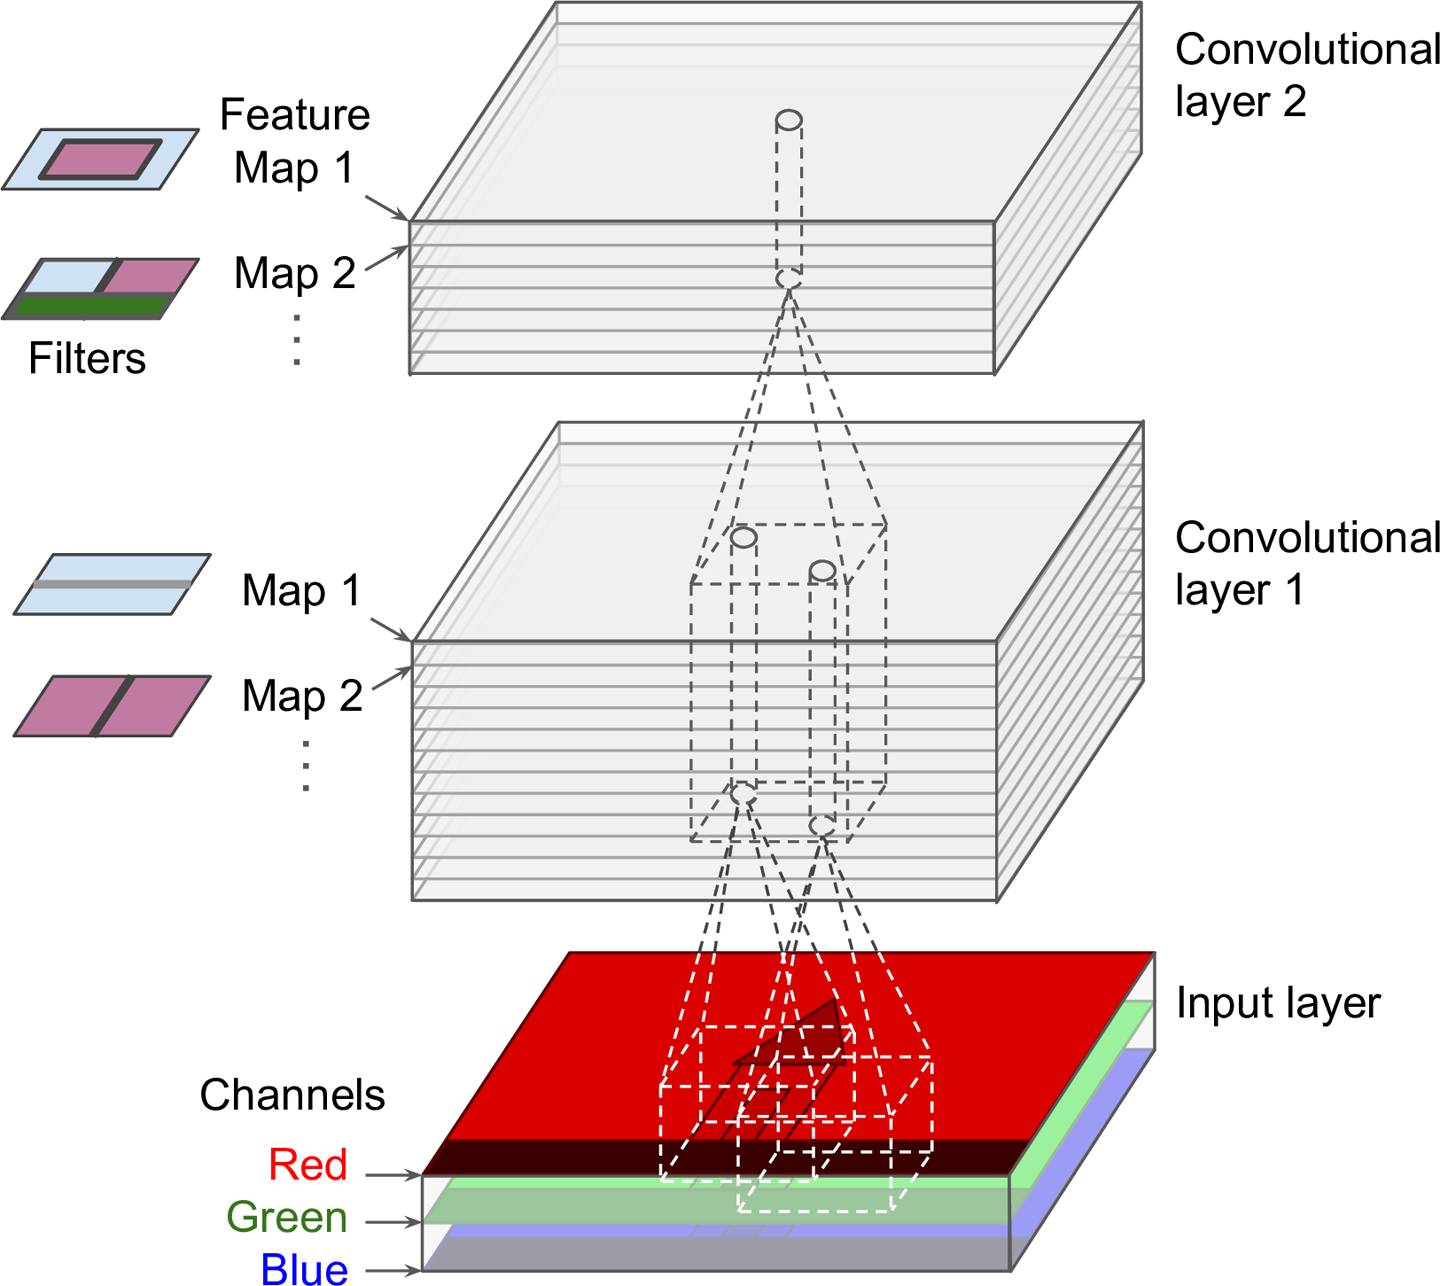

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

The convolutional layer in PyTorch is implemented by the class [`torch.nn.Conv2d`](
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
). The first three parameters of its constructor are mandatory, they are: the number of maps in the input, the number of maps in the output, the size of the kernel (one number if it has to be square or a pair of numbers if it has to be a rectangle).

We will be building step by step an array of `layers`, in which we will be placing the next layers of our neural network.
We will start by adding a convolutional layer.
MNIST images are monochrome, so we have only 1 input channel.
We will assume that we will have 5 maps in the output, each based on a square filter of side 3.
In order not to shrink the image too quickly, we will add 1 padding pixel on each side - as shown above.

In [11]:
layers = [
    nn.Conv2d(1, 5, 3, padding=1)
]

### Non-linearity

A convolutional layer - like a linear layer (`nn.Linear`) - is just a sum. It doesn't make sense to directly assemble several convolutional layers one on top of the other, we need nonlinearity. We will use *leaky ReLU*, the activation function shown in the following graph

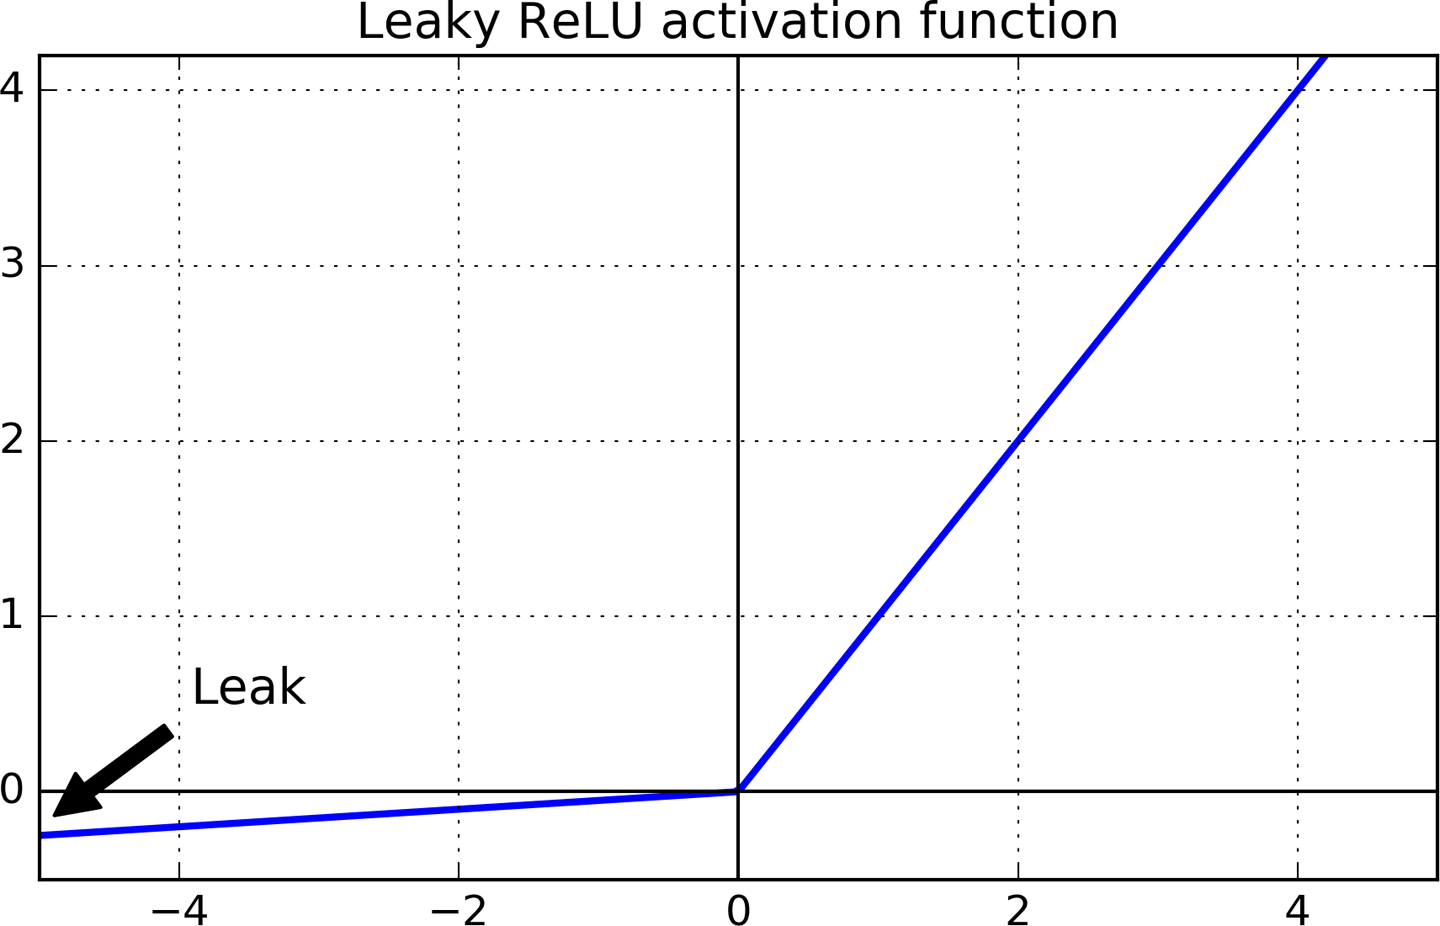
Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

In [12]:
layers.append(nn.LeakyReLU())

### Pooling

A convolutional network allows you to highlight certain features in an image, for example in the figure below, vertical lines are highlighted on the left in the map and horizontal lines are highlighted on the right.

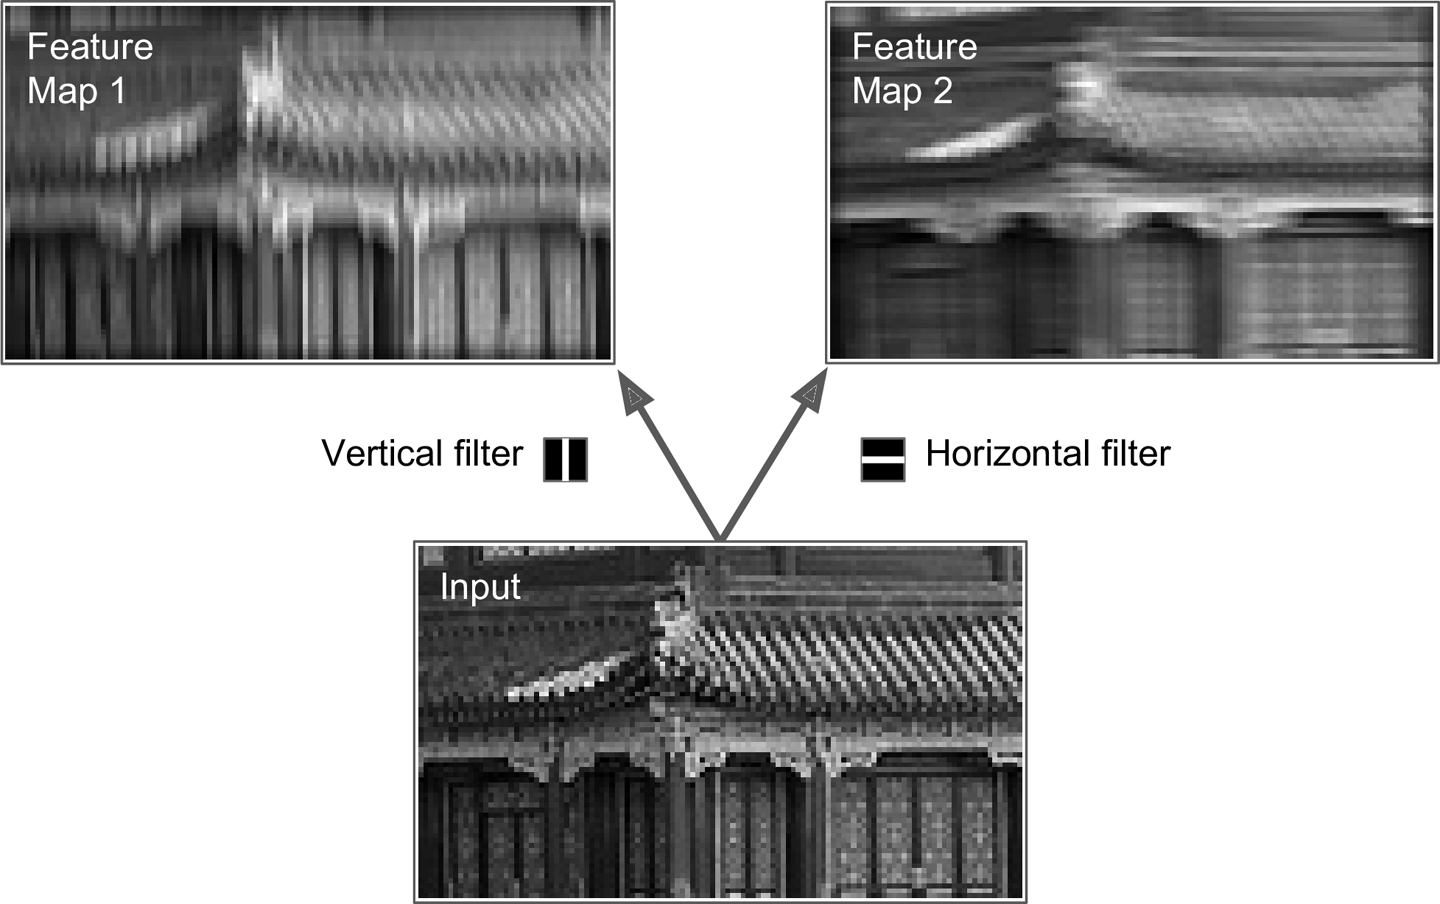

Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

On the other hand, this highlighting causes us to lose some detail because of the stride, and we don't actually need that much resolution anymore. With help comes the *pooling* operation, which, like a convolutional layer, moves a filter through the image, but this filter is parameterless: it is used either to select a maximum (*max pooling*) or to compute an arithmetic average (*average pooling*). The following figure roughly shows the idea of *max pooling* (kernel $2\times 2$, stride 2, no padding - hence $\times$ in the last column). For the pooling operation, there is no problem in moving to color image processing - each map (channel) is analyzed separately, so we always remain in two dimensions while performing this operation.

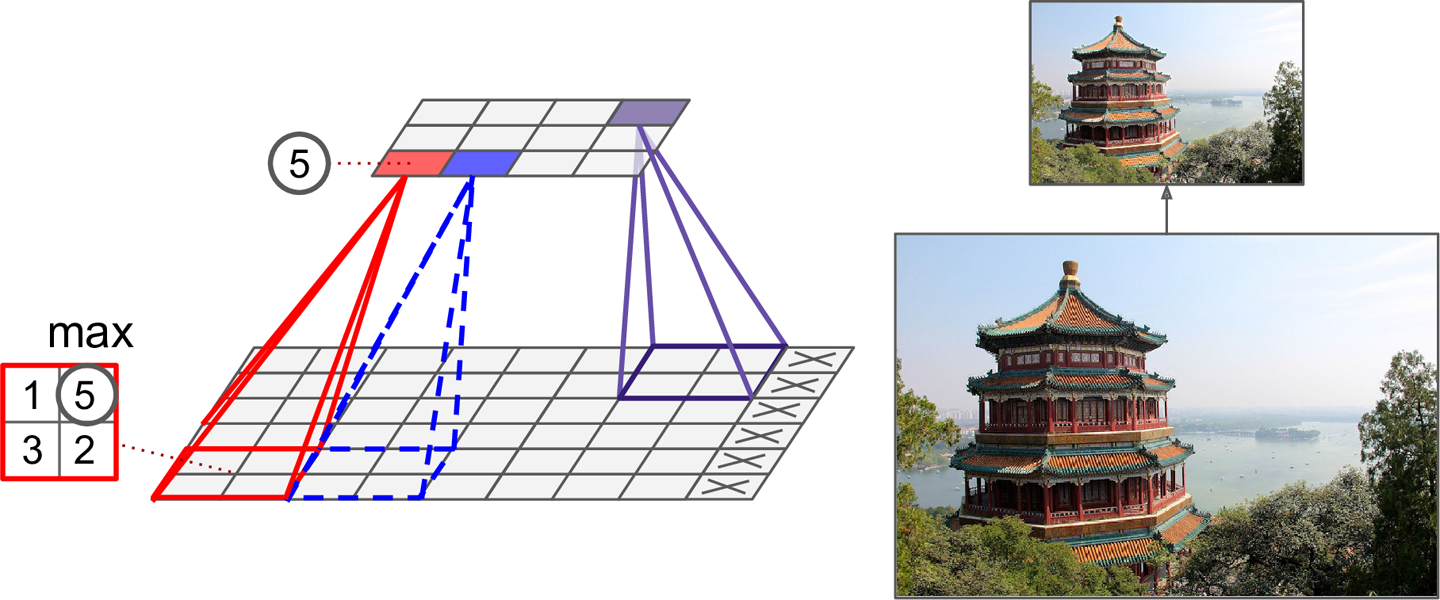
Aurélien Géron "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow" O'Reilly Media 2017

We will add *max pooling* to our neural network, implemented using the `nn.MaxPool2d` class, with a kernel size of $3\times 3$ and a padding of 1 pixel on each side.

In [13]:
layers.append(nn.MaxPool2d(3, padding=1))

We now have 5 maps of the size $10 \times 10$.



### Flattening

At this stage, each object processed by our neural network is three-dimensional, that is, it consists of a number of two-dimensional maps. We cannot give such input to a linear layer. We will use the `nn.Flatten` class to arrange the pixels one by one in a vector form.

In [14]:
layers.append(nn.Flatten())

### Linear layer

We will use the `nn.Linear` layer for classification. We are classifying to 10 classes, so we must have 10 units, but how many inputs do we need?


In [15]:
layers.append(nn.Linear(500, 10))

### The actual construction of the neural network

PyTorch is based on modules (objects of class `torch.nn.Module`) which are embedded in a computation graph. Each module can use parameters (objects of class `torch.nn.Parameter`) for which gradients can be automatically computed and which are (potentially) subject to optimization.

Neural networks are composed of layers and modules that perform data operations. The `torch.nn` namespace provides all the components necessary for the creation of your own neural network, which is a module itself, consisting of other modules (layers). This nested structure facilitates building complex architectures.
We will combine the layers into a single module using the `nn.Sequential` class, use cross entropy as the loss function, and use the Adam optimizer for optimization.

We will use the `torch.optim.Adam` class, which implements some improvement to the Gradient Descent algorithm. We create an `opt` object that will be responsible for optimizing the parameters obtained by calling `model.parameters()`.

In [16]:
model = nn.Sequential(*layers)

cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

In [17]:
model

Sequential(
  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=500, out_features=10, bias=True)
)

## Learning with early stopping

*Early stopping* is that every certain number of learning epochs, we compute an evaluation measure (e.g., classification accuracy) on the validation set. If there is an improvement over the previous time, we store the current values of the neural network weights, and if there is no improvement for several times, we stop learning and restore the weights of the last best model.

We prepare a helper function to compute the classification *accuracy*. In each row of `logits`, we select the column number with the largest value, compare it with the expected value, and average the values so obtained (0 or 1) over the examples to obtain the classification accuracy.

In [18]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [19]:
train_loss = []
validation_acc = []
best_model = None
best_acc = None
best_epoch = None
max_epoch = 100
no_improvement = 5
batch_size = 512

for n_epoch in range(max_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()
        epoch_loss.append(loss.detach())
    train_loss.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y).detach()
    validation_acc.append(acc)
    if best_acc is None or acc > best_acc:
        print("New best epoch ", n_epoch, "acc", acc)
        best_acc = acc
        best_model = model.state_dict()
        best_epoch = n_epoch
    if best_epoch + no_improvement <= n_epoch:
        print("No improvement for", no_improvement, "epochs")
        break

model.load_state_dict(best_model)

New best epoch  0 acc tensor(0.8157)
New best epoch  1 acc tensor(0.8854)
New best epoch  2 acc tensor(0.9070)
New best epoch  3 acc tensor(0.9205)
New best epoch  4 acc tensor(0.9308)
New best epoch  5 acc tensor(0.9364)
New best epoch  6 acc tensor(0.9419)
New best epoch  7 acc tensor(0.9441)
New best epoch  8 acc tensor(0.9488)
New best epoch  9 acc tensor(0.9507)
New best epoch  10 acc tensor(0.9541)
New best epoch  11 acc tensor(0.9549)
New best epoch  12 acc tensor(0.9568)
New best epoch  13 acc tensor(0.9582)
New best epoch  14 acc tensor(0.9597)
New best epoch  15 acc tensor(0.9615)
New best epoch  17 acc tensor(0.9619)
New best epoch  18 acc tensor(0.9627)
New best epoch  20 acc tensor(0.9643)
New best epoch  24 acc tensor(0.9654)
New best epoch  25 acc tensor(0.9655)
New best epoch  26 acc tensor(0.9668)
New best epoch  30 acc tensor(0.9676)
No improvement for 5 epochs


<All keys matched successfully>

Take a look at the charts below

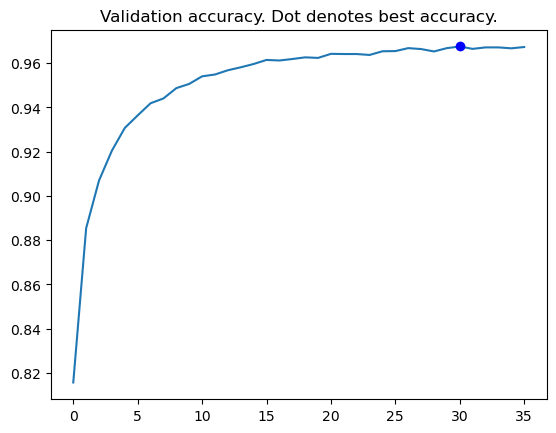

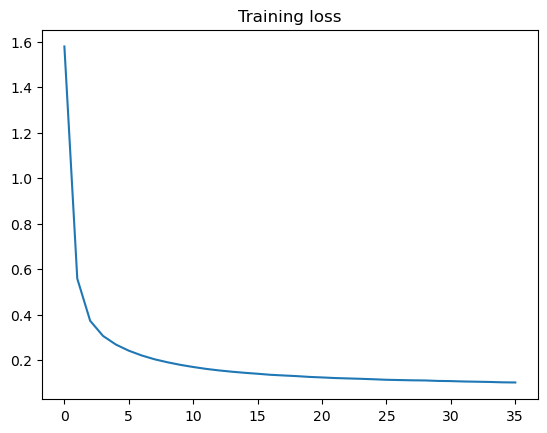

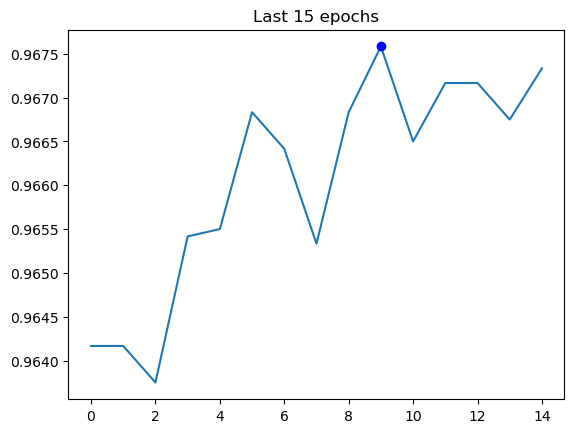

In [20]:
plt.title('Validation accuracy. Dot denotes best accuracy.')
plt.plot(validation_acc, label='Validation accuracy')
plt.plot(best_epoch, best_acc, 'bo', label='Best accuracy')
plt.show()
plt.title('Training loss')
plt.plot(train_loss)
plt.show()
k = max(3*no_improvement, 0)
plt.title('Last {} epochs'.format(k))
plt.plot(validation_acc[-k:])
plt.plot(best_epoch-(len(validation_acc)-k), best_acc, 'bo')
plt.show()

## Regularization

Our neural network should perform well not only on the training dataset, but also on the new, previously unseen data that it was not trained on.

When our model is too complex, it may start to learn the irrelevant information and noise in the dataset. Specific type of noise may only appear in the training dataset, and if the model 'memorizes' it, the model may become less accurate when being applied on the new data, where this specific type of noise is not present. 
Such a model is **overfitted**, i.e., does not generalize well to new data that slightly deviates from the data used during training. 

There are several methods to reduce overfitting such as: making the model more simple, early stopping, adding more data to the training set, and regularization. 

The common method of regularization is to add a penalty to the loss function such that the input parameters with the larger coefficients are more penalized:  
- L1 regularization: adding the absolute value of all weights to the loss value
- L2 regularization: adding the squared value of all weights to the loss value

Another common method is called **dropout**, where randomly selected units are ignored during training in each iteration. 

PyTorch provides `torch.nn.Dropout(p=0.5, inplace=False)` to apply dropout to a subsequent layer. The parameter `p` is the dropout rate -- the probability of an element to be zeroed (e.g., `nn.Dropout(p=0.2)`).

## TODO: 
Create a new model, identical to the existing one, except that it has a Dropout layer before the Linear linear layer. Train your new neural network on MNIST, experimenting with different dropout rates to see how it compares to traning without dropout.

New best epoch  0 acc tensor(0.1202)
No improvement for 5 epochs


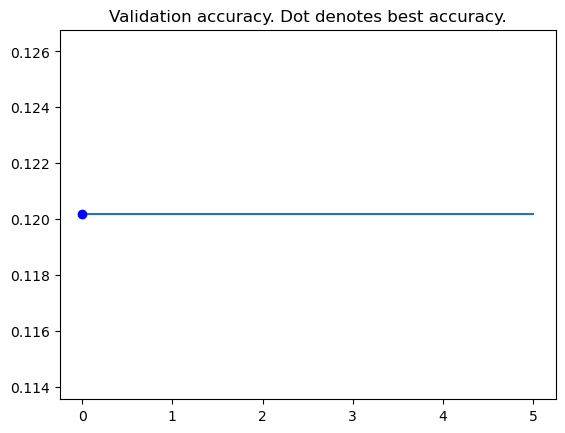

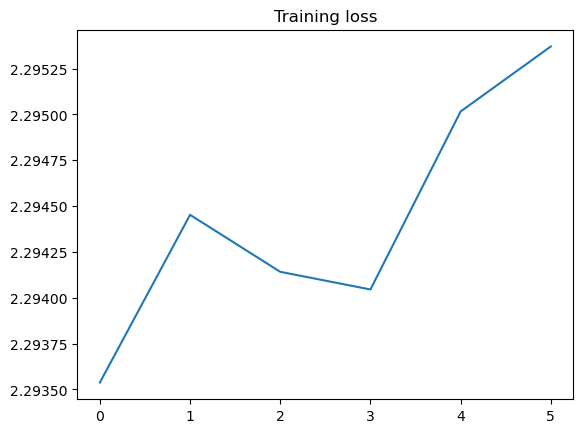

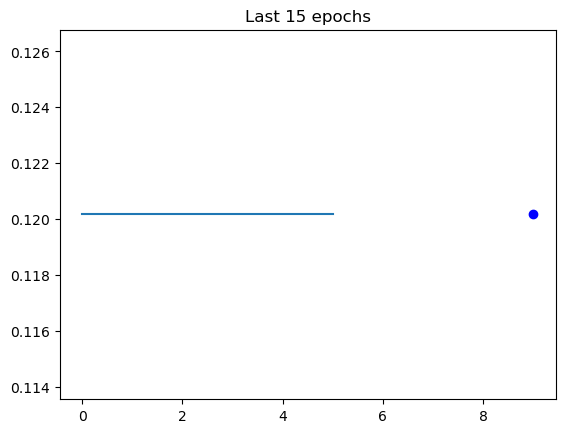

In [ ]:
class ModelDropout(nn.Module):
    def __init__(self):
        super(ModelDropout, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 5, 3, padding=1),
            
            nn.LeakyReLU(),
            nn.MaxPool2d(3, padding=1),
            nn.Flatten(),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(500, 10)
        )
    
    def forward(self, x):
        return self.network(x)
    

model = ModelDropout()

train_loss = []
validation_acc = []
best_model = None
best_acc = None
best_epoch = None
max_epoch = 100
no_improvement = 5
batch_size = 512

for n_epoch in range(max_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()
        epoch_loss.append(loss.detach())
    train_loss.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y).detach()
    validation_acc.append(acc)
    if best_acc is None or acc > best_acc:
        print("New best epoch ", n_epoch, "acc", acc)
        best_acc = acc
        best_model = model.state_dict()
        best_epoch = n_epoch
    if best_epoch + no_improvement <= n_epoch:
        print("No improvement for", no_improvement, "epochs")
        break

model.load_state_dict(best_model)


plt.title('Validation accuracy. Dot denotes best accuracy.')
plt.plot(validation_acc, label='Validation accuracy')
plt.plot(best_epoch, best_acc, 'bo', label='Best accuracy')
plt.show()
plt.title('Training loss')
plt.plot(train_loss)
plt.show()
k = max(3*no_improvement, 0)
plt.title('Last {} epochs'.format(k))
plt.plot(validation_acc[-k:])
plt.plot(best_epoch-(len(validation_acc)-k), best_acc, 'bo')
plt.show()